# Implementing Discrete Fourier Transform(DFT) Using Python

## Table of Contents
* [Introduction](#Introduction)
* [Python Implementation](#Implementation)
* [Testing the Code](#Testing)
* [Conclusion](#Conclusion)

<a name="Introduction"></a>

## Introduction

Digital images are usually stored and displayed in **space domain**. That is, each point/pixel in the image contains an integer value that shows the color intensity value. For example, if we have 8x8 image, then there are 64 values that are stored in each pixel location.

However, images can be transformed in to their corresponding **frequecy domain** representation. The advantage of the transformation is that several image processing tasks are well done in their transformed format. For example, they can be used for:

* *Image Enhancement*
* *Image Restoration*
* *Image Coding*
* *Image Compression*

Then, after these processes are performed, the processed image can be returned back to its original space domain form by using inverse transform process. There are several types of transforms, such as:

* *Discrete Fourier Transform (DFT)*
* *Discrete Cosine Transform (DCT)*
* *Walsh-Hadamard Transform*
* *Haar Transform*

In this homework, we are only concerned with DFT. 

A 2-dimensional DFT (2D-DFT) decomposes an image into its sinusoidal components (sines and cosines). As explained above, the input is the image in its **spatial domain**. In contrast, the output will be the image's representation in its fourier or **frequency domain**. DFT is a complex number transform as it has both the real (cosine) and imaginary (sine) components as an output.

Let the size of an input image be NxN. The general form is:

$$
\begin{align}
F(u,v) = \frac{1}{N^2}\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}f(x,y) e^{(-j2\pi\frac{ux+vy}{N})} \; where \; u,v=0,1,2,...N-1
\end{align}
$$

The above formula is **forward DFT transformation**.

Similarly, for **inverse DFT transformation**:
$$
\begin{align}
f(u,v) = \sum_{u=0}^{N-1}\sum_{v=0}^{N-1}F(u,v) e^{(+j2\pi\frac{ux+vy}{N})} \; where \; x,y=0,1,2,...N-1
\end{align}
$$

* $ k(x,y,u,v)=e^{(-j2\pi\frac{ux+vy}{N})} $ is called **basis function (kernel function)**

To find the real and imaginary part of the transformed image:

$$
\begin{align}
* e^{\pm jx} = \cos(x)\pm j\sin(x)
\end{align}
$$

Since the kernel function in DFT is separable:
$$\begin{align}
k(x,y,u,v)=e^{(-j2\pi\frac{ux+vy}{N})} = e^{(-j2\pi\frac{ux}{N})}e^{(-j2\pi\frac{vy}{N})}
\end{align}$$

$$\begin{align}
k(x,y,u,v) = k_1(x,u).k_2(v,y)
\end{align}
$$

So, the 2D-DFT formula can be computed as a sequence of two 1D-DFT transform. That is, each row of the original image is transformed and then each column of the previous result is transformed. This can be visualized as follows and was taken from [here](http://web.cs.wpi.edu/~emmanuel/courses/cs545/S14/slides/lecture10.pdf):

![2D-DFT Separability](Images/DFT-Separability.png "2D-DFT Separability")

Similarly, we can also apply the same technique to compute the inverse transformation:

For the forward transformation:

$$\begin{align}
F(u, v) = k_f(u,x) \;f(x,y) \; k_f(y,v)^{T*} \; where \; T* = Matrix \; transpose \; and \; conjugate 
\end{align}
$$

And for the inverse transformation:

$$\begin{align}
f(x, y) = k_i(x,u) \; F(u,v) \; k_i^{T*} 
\end{align}
$$

Where:
* $ k_f $ = **kernel** function of the **forward** transformation

* $ k_i $= **kernel** function of the **inverse** transformation*

* $ k_i = k_f^{-1} $ and $ k_i = k_f^T $ (Since the kernel function is **orthogonal**).

* And $ k_f = k_f^{T}$ (Since it is a **symmetric** function)

* So, $ k_i = k_f^{*T}$

Therefore:
$$\begin{align}
f(x, y) = k_f(x,u)^{*} \; F(u,v) \; k_f
\end{align}
$$

In the next section, the forward DFT will be implemented in python. Finally they will be tested with images of different sizes. And their running time will be computed and visualized.

<a name="Implementation"></a>

## Python Implementation

First of all, let's import the necessary python libraries

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import matplotlib.image as img
import PIL.Image as Image 

import math
import cmath

import time

import csv

Now let's start with creating common image functions.

In [3]:
def generateBlackAndWhiteSquareImage(imgSize):
    """
    Generates a square-sized black and white image with a given input size.

    Parameters
    ----------
    imgSize : int
        Input number that stores the dimension of the square image to be generated.

    Returns
    -------
    imge : ndarray
        The generated black and white square image.
    """

    #Creating a matrix with a given size where all the stored values are only zeros (for initialization)
    imge = np.zeros([imgSize, imgSize], dtype=int)

    #Starting and ending indices of the white part of the image.
    ind1 = imgSize/4
    ind2 = ind1 + (imgSize/2)

    #Make a part of the image as white (255)
    imge[ind1:ind2, ind1:ind2] = np.ones([imgSize/2, imgSize/2], dtype=int)*255

    #return the resulting image
    return imge
    
def generateImagesWithResizedWhite(imge):
    """
    Generates images with the same size as the original but with a resized white part of them.
    """

    N = imge.shape[0]

    imges = []
    i = N/2
    while i >= 4:
        j = (N - i)/2

        #Starting and ending indices for the white part.
        indx1 = j
        indx2 = j+i

        #Draw the image.
        imgeNew = np.zeros([N, N],dtype=int)
        imgeNew[indx1:indx2, indx1:indx2] = np.ones([i, i], dtype=int)*255

        #Add the image to the list.
        imges.append(imgeNew)

        i = i/2

    return imges

def resizeImage(imge, newSize):        
    """
    Reduces the size of the given image.

    Parameters
    ----------
    imge : ndarray
        Input array that stores the image to be resized.

    Returns
    -------
    newSize : int
        The size of the newly generated image.
    """

    #Compute the size of the original image (in this case, only # of rows as it is square)
    N = imge.shape[0]

    #The ratio of the original image as compared to the new one.
    stepSize = N/newSize

    #Creating a new matrix (image) with a black color (values of zero)
    newImge = np.zeros([N/stepSize, N/stepSize])

    #Average the adjacent four pixel values to compute the new intensity value for the new image.
    for i in xrange(0, N, stepSize):
        for j in xrange(0, N, stepSize):
            newImge[i/stepSize, j/stepSize] = np.mean(imge[i:i+stepSize, j:j+stepSize])

    #Return the new image
    return newImge


As a next step, the main class that implements a 2D DFT. Both the forward and inverse DFT will be implemented here.

*<u>Note:</u> All the input images are assumed to be square in size. But the implementation can easily be modified to work with rectangular images (not squares).*

In [4]:
class DFT(object):
    """
    This class DFT implements all the procedures for transforming a given 2D digital image
    into its corresponding frequency-domain image (Forward DFT Transform)
    """
    
    @classmethod
    def __computeConjugate(self, mat):
        """
        Computes the conjugate of a complex square-matrix.

        Parameters
        ----------
        mat : ndarray
            Input matrix of complex numbers.

        Returns
        -------
        result : ndarray
            The conjugate of the input matrix.
        """
        
        N = mat.shape[0]
        result = np.zeros([N, N], dtype=np.complex)
        
        for i in range(N):
            for j in range(N):
                result[i, j] = (mat[i, j].real) - (mat[i, j].imag*1j)

        return result
    
    @classmethod
    def __multiplyMatrices(self, mat1, mat2):
        """
        Computes the multiplication of two complex square matrices.

        Parameters
        ----------
        mat1 : ndarray
            First input matrix of complex numbers.
        mat2 : ndarray
            Second input matrix of complex numbers.
            
        Returns
        -------
        result : ndarray
            The multiplication result of the two matrices.
        """
        
        N = mat1.shape[0]
        
        result = np.zeros([N, N], np.complex)
        #For each column and row...
        for i in range(N):
            row = mat1[i, :]
            for j in range(N):
                col = mat2[j, :]
                total = 0 + 0j
                for k in range(N):
                    total += row[k]*col[k]
                result[i, j] = total
        
        return result
        
    #Compute the two separable kernels for the forward DFT.
    @classmethod
    def computeXForwardKernel(self, size):
        """
        Computes/generates the first forward kernel function.

        Parameters
        ----------
        size : int
            Size of the kernel to be generated.

        Returns
        -------
        xKernel : ndarray
            The generated kernel as a matrix.
        """
        
        #Initialize the kernel
        xKernel = np.zeros([size, size], dtype=np.complex)
        
        #Compute each value of the kernel...
        for u in range(size):
            for x in range(size):
                
                #Rounding it is used here for making the values integers as it will insert very small fractions.
                xKernel[u, x] = math.cos((2*math.pi*u*x)/size) - (1j*math.sin((2*math.pi*u*x)/size))
        
        #Return the resulting kernel
        return xKernel

    @classmethod
    def computeYForwardKernel(self, xKernel):
        """
        Computes/generates the second forward kernel function.

        Parameters
        ----------
        xKernel : ndarray
            The first forward kernel function.

        Returns
        -------
        yKernel : ndarray
            The generated kernel as a matrix.
        """
        #yKernel = np.conj(xKernel) ## In numpy package.
        N = xKernel.shape[0]
        
        #For each value, find the conjugate...
        yKernel = np.zeros([N, N], dtype=np.complex)
        for i in range(N):
            for j in range(N):
                yKernel[i, j] = (xKernel[i, j].real) - (xKernel[i, j].imag*1j)
                
        # Return the resulting kernel (Since the original kernel is symmetric, transpose is not needed)
        return yKernel
    
    @classmethod
    def computeCenteredImage(self, imge):
        """
        Centers a given image.

        Parameters
        ----------
        imge : ndarray
            Input array that stores the image to be centered.

        Returns
        -------
        newImge : int
            The new and centered version of the input image.
        """
        
        #Compute the dimensions of the image
        M, N = imge.shape
        #centeringMatrix = np.zeros([M, N], dtype=int)
        newImge = np.zeros([M, N], dtype=int)
        for x in range(M):
            for y in range(N):
                newImge[x, y] = imge[x, y] * ((-1)**(x+y))

        #newImge = imge * centeringMatrix
        return newImge
    
    @classmethod
    def computeForward2DDFTWithSeparability(self, imge):
        """
        Computes/generates the 2D DFT by computing the two forward kernels first (Separability).

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DDFT : ndarray
            The transformed image.
        """
        
        N = imge.shape[0]
        xKernel = DFT.computeXForwardKernel(N)
        yKernel = DFT.computeYForwardKernel(xKernel)

        #row1DDFT = (1.0/size) * np.dot(xKernel, imge)
        intermediate2DDFT = (1.0/N) * DFT.__multiplyMatrices(xKernel, imge)
        final2DDFT = (1.0/N) * DFT.__multiplyMatrices(intermediate2DDFT, yKernel)

        return final2DDFT
        
    @classmethod
    def __computeSinglePoint2DFT(self, imge, u, v, N):
        """
        A private method that computes a single value of the 2DDFT from a given image.

        Parameters
        ----------
        imge : ndarray
            The input image.
        
        u : ndarray
            The index in x-dimension.
            
        v : ndarray
            The index in y-dimension.

        N : int
            Size of the image.
            
        Returns
        -------
        result : complex number
            The computed single value of the DFT.
        """
        result = 0 + 0j
        for x in xrange(N):
            for y in xrange(N):
                result += (imge[x, y] * (math.cos((2*math.pi*(u*x + v*y))/N) - 
                                         (1j*math.sin((2*math.pi*(u*x + v*y))/N))))
        return result
    
    @classmethod
    def computeForward2DDFTNoSeparability(self, imge):
        """
        Computes/generates the 2D DFT by computing without separating the kernels.

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DDFT : ndarray
            The transformed image.
        """
 
        # Assuming a square image
        N = imge.shape[0]
        final2DDFT = np.zeros([N, N], dtype=np.complex)
        for u in xrange(N):
            for v in xrange(N):
                #Compute the DFT value for each cells/points in the resulting transformed image.
                final2DDFT[u, v] = DFT.__computeSinglePoint2DFT(imge, u, v, N)
        return ((1.0/(N**2))*final2DDFT)
    
    @classmethod
    def computeInverse2DDFTWithSeparability(self, dftImge):
        """
        Computes the inverse 2D DFT by computing the two inverse kernels first (Separability).

        Parameters
        ----------
        dftImge : ndarray
            The dft transformed image as input.

        Returns
        -------
        imge : ndarray
            The resulting image in spatial domain from the inverse DFT.
        """
        
        N = dftImge.shape[0]
        
        #Here the kernels are interchanged from the forward DFT
        yKernel = DFT.computeXForwardKernel(N)
        xKernel = DFT.computeYForwardKernel(yKernel)

        intermediateImge = DFT.__multiplyMatrices(xKernel, dftImge)
        imge = DFT.__multiplyMatrices(intermediateImge, yKernel)
        
        #imge = np.real(imge)

        return imge       

    @classmethod
    def compute2DDFTFourierSpectrum(self, dftImge):
        """
        Computes the fourier spectrum of the transformed image.

        Parameters
        ----------
        dftImge : ndarray
            The input transformed image.

        Returns
        -------
        fourierSpect : ndarray
            The computed fourier spectrum.
        """
        N = dftImge.shape[0]
        
        fourierSpect = np.zeros([N, N], dtype=float)
        #Calculate the magnitude of each point(complex number) in the DFT image
        for i in xrange(N):
            for j in xrange(N):
                v = dftImge[i, j]
                fourierSpect[i, j] = math.sqrt((v.real)**2 + (v.imag)**2)
        return fourierSpect
    
    @classmethod
    def normalize2DDFTByLog(self, dftImge):
        """
        Computes the log transformation of the transformed DFT image to make the range
        of the fourier values b/n 0 to 255
        
        Parameters
        ----------
        dftImge : ndarray
            The input transformed image.

        Returns
        -------
        dftNormImge : ndarray
            The normalized version of the transformed image.
        """
        
        #Compute the fourier spectrum of the transformed image:
        dftFourierSpect = DFT.compute2DDFTFourierSpectrum(dftImge)
        
        #Normalize the fourier spectrum values:
        dftNormFourierSpect = (255.0/ math.log10(255)) * np.log10(1 + (255.0/(np.max(dftFourierSpect))*dftFourierSpect))
        
        return dftNormFourierSpect
        

<a name="Testing"></a>

<a name="Testing"></a>

## Testing the Code and Visualizing the DFT Running Time

### Testing the DFT algorithm

For testing purposes, the 4x4 separable DFT kernels are computed:

In [5]:
# The numbers are rounded for visualization
xKernel = np.round(DFT.computeXForwardKernel(4))
print "The first 4x4 forward kernel:"
xKernel

The first 4x4 forward kernel:


array([[ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  0.-1.j, -1.-0.j, -0.+1.j],
       [ 1.+0.j, -1.-0.j,  1.+0.j, -1.-0.j],
       [ 1.+0.j, -0.+1.j, -1.-0.j,  0.-1.j]])

In [6]:
# The second kernel is the conjugate of the first (as the kernels are symmetric, we don't need to transpose)
yKernel = np.round(DFT.computeYForwardKernel(xKernel))
print "The first 4x4 forward kernel:"
yKernel

The first 4x4 forward kernel:


array([[ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  0.+1.j, -1.+0.j, -0.-1.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j, -0.-1.j, -1.+0.j,  0.+1.j]])

Here, we generate an 8-bit gray scale image as a 64x64 matrix

In [7]:
imge = generateBlackAndWhiteSquareImage(64)

Generate images of the same size as above but with different white part size:

In [8]:
imges = generateImagesWithResizedWhite(imge)

To test the DFT with different images having different white size:

Here, we will generate the images, compute the DFT and visualize the results:

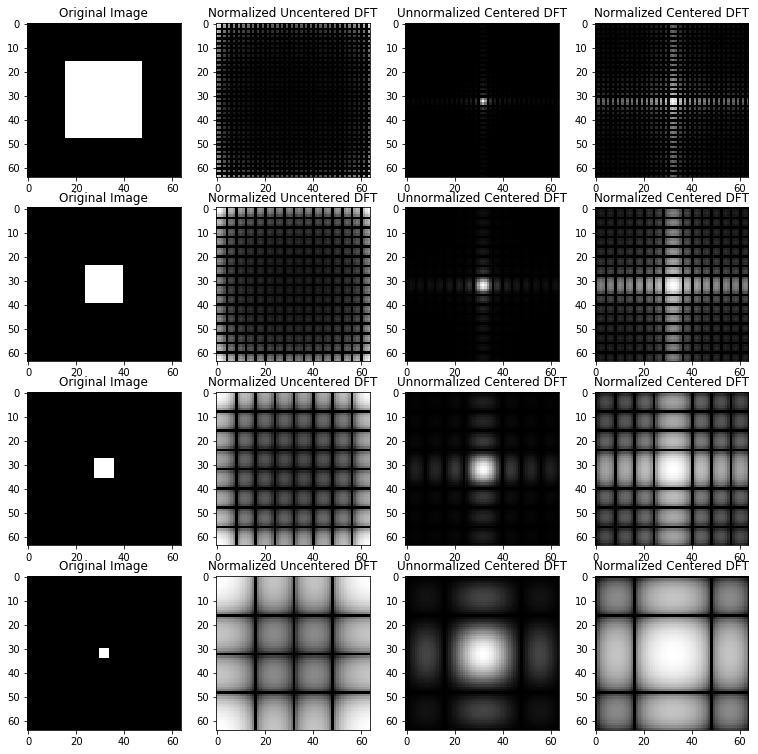

In [9]:
#For visualization:
N = len(imges) 
fig, axarr = plt.subplots(N, 4, figsize=(13, 13))

#Compute DFT for each generated image...
dftImges = []
for i, imge in enumerate(imges):
    
    #Center the generated image
    centeredImge = DFT.computeCenteredImage(imge)
    
    #Compute the 2D DFT transformation for both centered and uncentered images:
    dftUncenteredImge = DFT.computeForward2DDFTWithSeparability(imge)
    dftCenteredImge = DFT.computeForward2DDFTWithSeparability(centeredImge)
    
    #Save the centered DFT images...
    dftImges.append(dftCenteredImge)
    
    #Normalize the computed DFT results:
    dftUncenteredNormImge = DFT.normalize2DDFTByLog(dftUncenteredImge)
    dftCenteredNormImge = DFT.normalize2DDFTByLog(dftCenteredImge)
    
    #Display the normalized versions of the centered and uncentered images
    axarr[i][0].imshow(imge, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    axarr[i][0].set_title('Original Image')

    axarr[i][1].imshow(dftUncenteredNormImge, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    axarr[i][1].set_title('Normalized Uncentered DFT')

    axarr[i][2].imshow(DFT.compute2DDFTFourierSpectrum(dftCenteredImge), cmap=plt.get_cmap('gray'))
    axarr[i][2].set_title('Unnormalized Centered DFT')

    axarr[i][3].imshow(dftCenteredNormImge, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    axarr[i][3].set_title('Normalized Centered DFT')
    
#fig.suptitle("DFT FOR 64x64 IMAGES HAVING DIFFERENT WHITE COLOR SIZE")
#fig.subplots_adjust(top=2)
plt.show()

From the above results, we can see that the white color size in the original and transformed images are inversely proportional. This is similar to $\delta x \; and \; \frac{1}{\delta x} $ which are inversely proportional to one another.

Now let's compute the inverse DFT on the transformed images to check the correctness of our code:

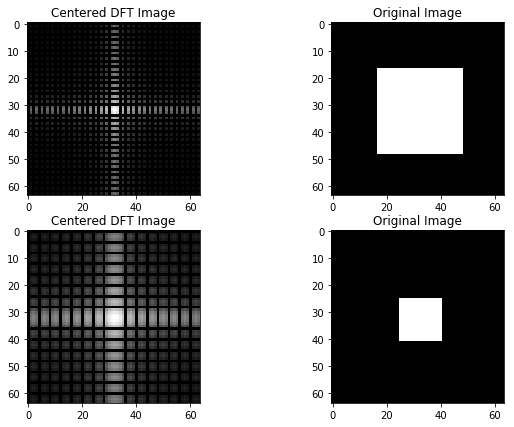

In [10]:
#For visualization:
N = len(dftImges)
fig, axarr = plt.subplots(2, 2, figsize=(10,7))

#Compute the inverse DFT for only the first two transformed images...
for i, dftImge in enumerate(dftImges[:2]):
    
    #Compute the inverse DFT and take the real part
    imge = np.real(DFT.computeInverse2DDFTWithSeparability(dftImge))
    
    #Due to the floating point precision, we can get very small decimal points,
    #So let's round them to the nearest integer.
    imge = np.round(imge)
    
    #Since the images were originally centered, let's decenter them now
    imge = DFT.computeCenteredImage(imge)
    
    #Display the dft and the resulting images found with inverse DFT:
    dftNormImge = DFT.normalize2DDFTByLog(dftImge)
    axarr[i][0].imshow(dftNormImge, cmap=plt.get_cmap('gray'))
    axarr[i][0].set_title('Centered DFT Image')
    
    axarr[i][1].imshow(imge, cmap=plt.get_cmap('gray'))
    axarr[i][1].set_title('Original Image')

#fig.suptitle("The original 64x64 images found by applying inverse DFT", fontsize=14)
#fig.subplots_adjust(top=1.55)

plt.show()

### Computing and Visualizing the DFT Running Time

In this part, we will compute and visualize the running time of DFT for different image sizes.

First, the images with different sizes are generated:

In [11]:
def generateImages(imgSizes=[128, 64, 32, 16, 8]): 

    #Create an empty list of images to save the generated images with different sizes.
    images = []

    #Generate the first and biggest image
    imge = generateBlackAndWhiteSquareImage(imgSizes[0])

    #Add to the images list
    images.append(imge)

    #Generate the resized and smaller images with different sizes.
    for i in range(1, len(imgSizes)):
        size = imgSizes[i]
        images.append(resizeImage(imge, size))
        
    return images

Next, the DFT algorithm will be run for all the generated images with different sizes. In addition, the running time will also be saved.

In [12]:
#Generate images
imgSizes = [128, 64, 32, 16, 8]
images = generateImages(imgSizes)

# A list that stores the running time of the DFT algorithm for images with different size.
runningTimeDFT = []

#For each image...
for i, imge in enumerate(images):
    
    #Compute the image size
    N = imge.shape[0]
    
    print "Computing for ", N, "x", N, "image..."
    
    #Step 1: Center the image
    centeredImge = DFT.computeCenteredImage(imge)

    #Save the starting time.
    startTime = time.time()

    #Step 2: Compute the DFT of the image using the matrix multiplication form. 
    dftImge = DFT.computeForward2DDFTNoSeparability(centeredImge)
    
    #Save the running time
    runningTimeDFT.append((time.time() - startTime)/60.00)

Computing for  128 x 128 image...
Computing for  64 x 64 image...
Computing for  32 x 32 image...
Computing for  16 x 16 image...
Computing for  8 x 8 image...


Save the running time to file:

In [13]:
result = zip(imgSizes, runningTimeDFT)
np.savetxt("RunningTimes/runningTimeDFT.csv", np.array(result), delimiter=',')

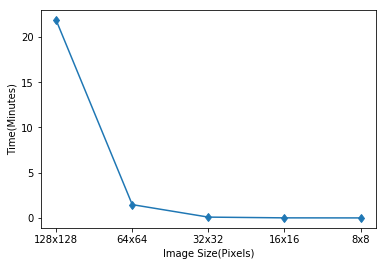

In [14]:
#Plot the running times
plt.plot(xrange(len(runningTimeDFT)), runningTimeDFT, '-d')

xlabels = [str(imge.shape[0]) + 'x' + str(imge.shape[0]) for imge in images]
plt.xticks(xrange(len(runningTimeDFT)), xlabels)
plt.xlabel("Image Size(Pixels)")
plt.ylabel("Time(Minutes)")
plt.show()

## Conclusion

In this post, we have implemented Discrete Fourier Transform (forward and reverse) from scratch. Then, we applied it to 2D images. 